## Capstone Project 1: Home Loan Credibility Assessment

### Statistical Data Analysis 

There are 122 features in the dataset. The importance of these features will be evaluated in this study.

Correlation tests will be performed with a feature against the target feature to check if they are related. I will use Kendall’s rank correlation in this study to test whether two features have a monotonic relationship. Chi-Squared test will be used to test whether categorical variables are related to the Target variable.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed

#from scipy.stats import t, norm
import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
# Set the style of plots
plt.style.use('fivethirtyeight')
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Read Data

In [2]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
df = pd.read_csv('./Data_Files/application_train.csv')
print('Training data shape: ', df.shape)

# Remove 4 applications with XNA CODE_GENDER (train set)
df = df[df['CODE_GENDER'] != 'XNA']

# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
# Categorical features with One-Hot encode
#df, cat_cols = one_hot_encoder(df, nan_as_category=False)

# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

df.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,0,0,0,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Correlation:

In [4]:
# Find correlations with the target and sort
correlations = df.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive (15) Correlations:\n', correlations.tail(15))
print('\nMost Negative (15) Correlations:\n', correlations.head(15))

Most Positive (15) Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032261
LIVE_CITY_NOT_WORK_CITY        0.032517
OWN_CAR_AGE                    0.037611
DAYS_REGISTRATION              0.041976
FLAG_DOCUMENT_3                0.044341
REG_CITY_NOT_LIVE_CITY         0.044394
FLAG_EMP_PHONE                 0.045984
REG_CITY_NOT_WORK_CITY         0.050992
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055219
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060895
DAYS_EMPLOYED                  0.074957
DAYS_BIRTH                     0.078242
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative (15) Correlations:
 EXT_SOURCE_3                 -0.178926
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155317
CODE_GENDER                  -0.054710
FLOORSMAX_AVG                -0.044009
FLOORSMAX_MEDI               -0.043773
FLOORSMAX_MODE               -0.043231
AMT_GOODS_PRICE              

### Target variable normality check:

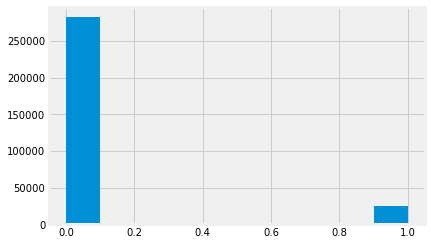

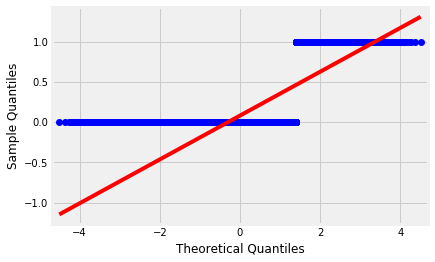

In [5]:
plt.hist(df['TARGET']) 
plt.show()
fig = sm.qqplot(df['TARGET'], line='s' )
plt.show()

In [6]:
# D’Agostino’s K^2 Test
stat, p = stats.normaltest(df['TARGET'])
print('stats: ', stat, ' , p-value: ', p)

# Interpretation
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)') 

stats:  186563.2820995757  , p-value:  0.0
Sample does not look Gaussian (reject H0)


### Client's Age on loan repayment

I want to observe is there a significant difference between the age groups in terms of loan repayment.

__Research questions: Is there any relation between age groups in terms of loan repayment?__

H0: There is no correlation between age groups and loan repayment.   
H1: Loan repayment is related to the age groups.


First to check wheather the client's age data is Gaussian or not.

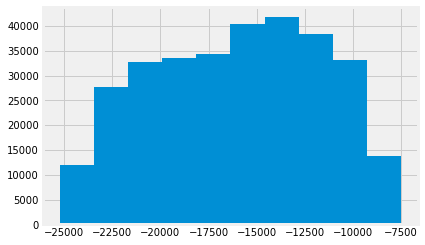

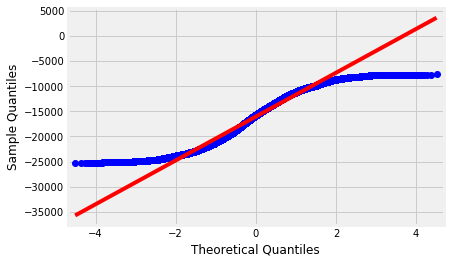

In [7]:
plt.hist(df['DAYS_BIRTH']) 
plt.show()
fig = sm.qqplot(df['DAYS_BIRTH'], line='s' )
plt.show()

In [8]:
# Shapiro-Wilk Test
stat, p = stats.shapiro(df['DAYS_BIRTH'])
print(stat, p)

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)') 

0.9696902632713318 0.0
Sample does not look Gaussian (reject H0)


D:\Programs\Anaconda3_072019\envs\pm36\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


                TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036  -8532.795625    23.377522
(25.0, 30.0]  0.111442 -10155.219690    27.822520
(30.0, 35.0]  0.102814 -11854.848377    32.479037
(35.0, 40.0]  0.089416 -13707.908041    37.555912
(40.0, 45.0]  0.078491 -15497.661233    42.459346
(45.0, 50.0]  0.074171 -17323.900441    47.462741
(50.0, 55.0]  0.066968 -19196.494791    52.593136
(55.0, 60.0]  0.055316 -20984.285455    57.491193
(60.0, 65.0]  0.052737 -22780.547460    62.412459
(65.0, 70.0]  0.037270 -24292.614340    66.555108


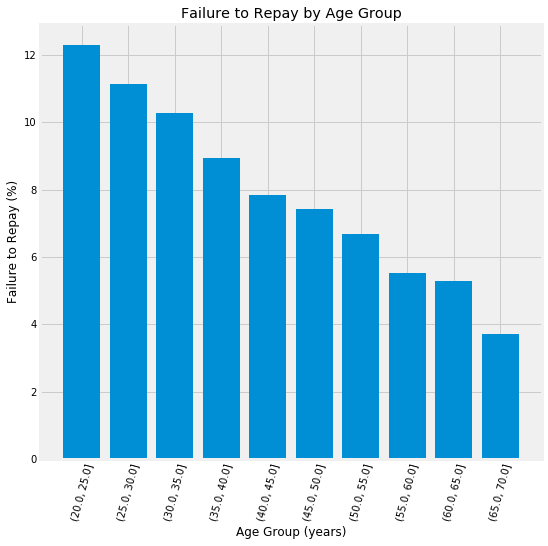

In [9]:
# Age information into a separate dataframe
age_data = df.loc[:,['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
print(age_groups)

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [10]:
corr, p = stats.kendalltau(age_groups.iloc[:,0], age_groups.iloc[:,2])
print('corr: ', corr, ', p-value: ', p)
# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.') 

corr:  -0.9999999999999999 , p-value:  5.511463844797178e-07
H1: there is a dependency between the samples.


Since the p-value is smaller than 0.05, the null hypothesis is rejected. There is a relation between loan repayment and the age groups.

### Client's Employment on loan repayment

I want to observe is there a significant difference between the years of employed in terms of loan repayment.

Research questions: Is there any relation between years employed interms of loan repayment?

H0: There is no correlation between years employed and loan repayment.    
H1: Loan repayment is related to the years employed.

Lets check that wheather the client's employment data is Gaussian or not.

D:\Programs\Anaconda3_072019\envs\pm36\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Programs\Anaconda3_072019\envs\pm36\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


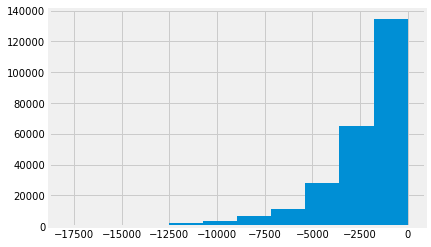

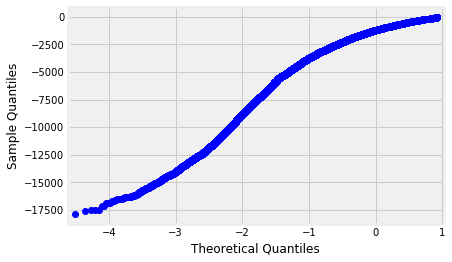

In [11]:
plt.hist(df['DAYS_EMPLOYED']) 
plt.show()
fig = sm.qqplot(df['DAYS_EMPLOYED'], line='s')
plt.show()

In [12]:
# Shapiro-Wilk Test
stat, p = stats.shapiro(df['DAYS_EMPLOYED'])
print(stat, p)

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)') 

nan 1.0
Sample looks Gaussian (fail to reject H0)


                TARGET  DAYS_EMPLOYED  YEARS_EMPLOYED
YEARS_BINNED                                         
(0.0, 1.0]    0.109685    -218.990064        0.599973
(1.0, 2.0]    0.114052    -541.915403        1.484700
(2.0, 3.0]    0.107166    -908.500287        2.489042
(3.0, 4.0]    0.101594   -1269.729681        3.478711
(4.0, 5.0]    0.091147   -1638.408071        4.488789
(5.0, 6.0]    0.081304   -1999.644588        5.478478
(6.0, 7.0]    0.076637   -2368.929871        6.490219
(7.0, 8.0]    0.072597   -2733.776958        7.489800
(8.0, 9.0]    0.068603   -3096.985999        8.484893


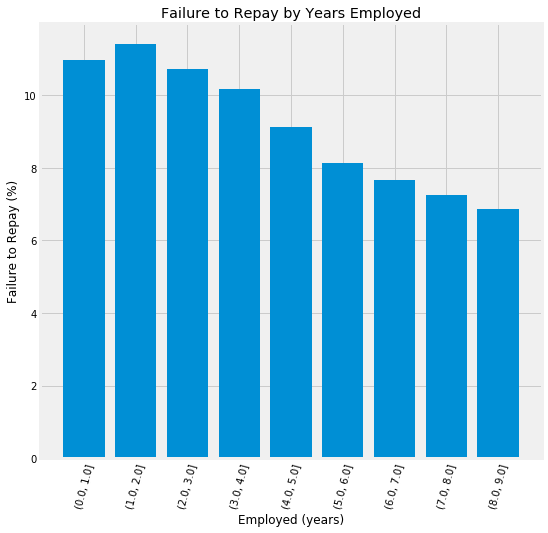

In [13]:
# Year of employment into a separate dataframe
emp_data = df.loc[:,['TARGET', 'DAYS_EMPLOYED']].copy()
emp_data['YEARS_EMPLOYED'] = emp_data['DAYS_EMPLOYED'] / -365

# Bin the Year of employment data
emp_data.dropna(inplace=True)
emp_data['YEARS_BINNED'] = pd.cut(emp_data['YEARS_EMPLOYED'], bins = np.linspace(0, 9, num = 10))

# Group by the bin and calculate averages
emp_groups  = emp_data.groupby('YEARS_BINNED').mean()
print(emp_groups)

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(emp_groups.index.astype(str), 100 * emp_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Employed (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Years Employed');


In [14]:
corr, p = stats.kendalltau(emp_groups.iloc[:,0], emp_groups.iloc[:,2])
print('corr: ', corr, ', p-value: ', p)
# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.') 

corr:  -0.9444444444444445 , p-value:  4.96031746031746e-05
H1: there is a dependency between the samples.


Since the p-value is smaller than 0.05, the null hypothesis is rejected. There is a relation between loan repayment and the years employed.

### Client's living region (city) on loan repayment

Research questions: Is there any relation between client's living region (city) on loan repayment?

H0: There is no correlation between client's living region (city) and loan repayment.            
H1: Loan repayment is related to the client's living region (city).

Lets check that wheather the client's living region (city) data is Gaussian or not.

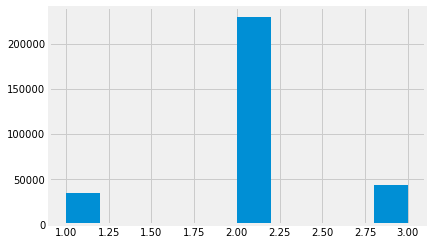

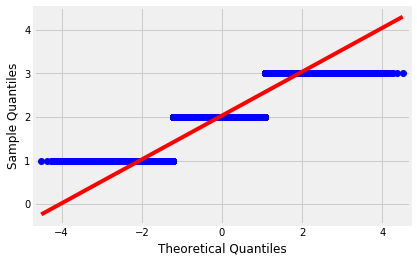

0.6829575300216675 0.0
Sample does not look Gaussian (reject H0)


In [15]:
plt.hist(df['REGION_RATING_CLIENT_W_CITY']) 
plt.show()
fig = sm.qqplot(df['REGION_RATING_CLIENT_W_CITY'], line='s')
plt.show()
# Shapiro-Wilk Test
stat, p = stats.shapiro(df['REGION_RATING_CLIENT_W_CITY'])
print(stat, p)

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)') 

                               TARGET
REGION_RATING_CLIENT_W_CITY          
1                            0.048409
2                            0.079179
3                            0.114024


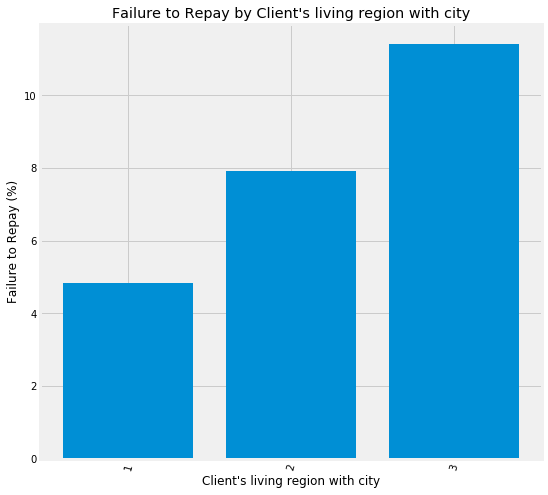

In [16]:
# Put the rating of the region with city where client lives into a separate dataframe
rgc_data = df.loc[:,['TARGET', 'REGION_RATING_CLIENT_W_CITY']].copy()
rgc_data.dropna(inplace=True)

# Group by the region and calculate averages
rgc_groups  = rgc_data.groupby('REGION_RATING_CLIENT_W_CITY').mean()
print(rgc_groups)

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(rgc_groups.index.astype(str), 100 * rgc_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Client\'s living region with city'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Client\'s living region with city');

In [17]:
corr, p = stats.kendalltau(rgc_groups.iloc[:,0], list(rgc_groups.index))
print('corr: ', corr, ', p-value: ', p)

# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.') 

corr:  1.0 , p-value:  0.3333333333333333
H0: the two samples are independent.


### Client's living region on loan repayment
Research questions: Is there any relation between client's living region on loan repayment?

H0: There is no correlation between client's living region and loan repayment.        
H1: Loan repayment is related to the client's living region.

In [18]:
# Put the rating of the region with city where client lives into a separate dataframe
rgc_data = df.loc[:,['TARGET', 'REGION_RATING_CLIENT']].copy()
rgc_data.dropna(inplace=True)

# Group by the region and calculate averages
rgc_groups  = rgc_data.groupby('REGION_RATING_CLIENT').mean()

corr, p = stats.kendalltau(rgc_groups.iloc[:,0], list(rgc_groups.index))
print('corr: ', corr, ', p-value: ', p)

# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.') 

corr:  1.0 , p-value:  0.3333333333333333
H0: the two samples are independent.


### External data sources on loan repayment

Research questions: Is there any relation between external data sources on loan repayment?

H0: There is no correlation between external data sources and loan repayment.    
H1: External data sources is related to the loan repayment.

Lets check that wheather the external data sources is Gaussian or not.

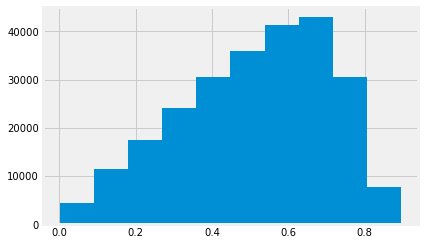

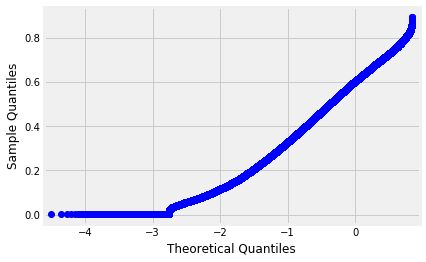

nan 1.0
Sample looks Gaussian (fail to reject H0)


In [19]:
plt.hist(df['EXT_SOURCE_3']) 
plt.show()
fig = sm.qqplot(df['EXT_SOURCE_3'], line='s')
plt.show()

# Shapiro-Wilk Test
stat, p = stats.shapiro(df['EXT_SOURCE_3'])
print(stat, p)

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)') 

In [20]:
ex3_data = df.loc[:,['TARGET', 'EXT_SOURCE_3']].copy()
ex3_data.dropna(inplace=True)

corr, p = stats.kendalltau(ex3_data.iloc[:,0], ex3_data.iloc[:,1])
print('corr: ', corr, ', p-value: ', p)

# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.') 

corr:  -0.13598507164649482 , p-value:  0.0
H1: there is a dependency between the samples.


In [21]:
ex3_data = df.loc[:,['TARGET', 'EXT_SOURCE_2']].copy()
ex3_data.dropna(inplace=True)

corr, p = stats.kendalltau(ex3_data.iloc[:,0], ex3_data.iloc[:,1])
print('corr: ', corr, ', p-value: ', p)

# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

corr:  -0.12029722465317395 , p-value:  0.0
H1: there is a dependency between the samples.


In [22]:
ex3_data = df.loc[:,['TARGET', 'EXT_SOURCE_1']].copy()
ex3_data.dropna(inplace=True)

corr, p = stats.kendalltau(ex3_data.iloc[:,0], ex3_data.iloc[:,1])
print('corr: ', corr, ', p-value: ', p)

# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

corr:  -0.1233965997070033 , p-value:  0.0
H1: there is a dependency between the samples.


There is a relation between external data sources and loan repayment.

### Client's gender on loan repayment

Research questions: Is there any relation between client's gender on loan repayment?

H0: There is no correlation between client's gender and loan repayment.    
H1: client's gender is related to the loan repayment.

Lets check that wheather the client's gender is Gaussian or not.

In [23]:
# Shapiro-Wilk Test
stat, p = stats.shapiro(df['CODE_GENDER'])
print('stat: ', stat, ', p-value: ',p)

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)') 

stat:  0.5982246398925781 , p-value:  0.0
Sample does not look Gaussian (reject H0)


In [24]:
crosstab = pd.crosstab(df['CODE_GENDER'], df['TARGET'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print('p-value: ',p)
# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  4.394091339983112e-202
H1: there is a dependency between the samples.


####  Relation between client own car on loan repayment

In [25]:
crosstab = pd.crosstab(df['FLAG_OWN_CAR'], df['TARGET'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print('p-value: ',p)
# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  9.410574445435375e-34
H1: there is a dependency between the samples.


####  Relation between client own house or flat on loan repayment

In [26]:
crosstab = pd.crosstab(df['FLAG_OWN_REALTY'], df['TARGET'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print('p-value: ',p)
# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  0.0006716541669272181
H1: there is a dependency between the samples.


####  Relation between if loan is cash or revolving on loan repayment

In [27]:
dummies = pd.get_dummies(df['NAME_CONTRACT_TYPE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print('p-value: ',p)
# Interpretation
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  1.1274999190439246e-65
H1: there is a dependency between the samples.


####  Relation between accompanying person with client on loan repayment

In [28]:
dummies = pd.get_dummies(df['NAME_TYPE_SUITE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  4.339400920054708e-06
H1: there is a dependency between the samples.


####  Relation between Client's income type on loan repayment

In [29]:
dummies = pd.get_dummies(df['NAME_INCOME_TYPE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  6.996531588495895e-223
H1: there is a dependency between the samples.


####  Relation between Client's education type on loan repayment

In [30]:
dummies = pd.get_dummies(df['NAME_EDUCATION_TYPE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  6.244278068516921e-168
H1: there is a dependency between the samples.


####  Relation between Client's family status type on loan repayment

In [31]:
dummies = pd.get_dummies(df['NAME_FAMILY_STATUS'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  6.567292088867877e-27
H1: there is a dependency between the samples.


####  Relation between Client's housing situation type on loan repayment

In [32]:
dummies = pd.get_dummies(df['NAME_HOUSING_TYPE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  6.836805842473723e-62
H1: there is a dependency between the samples.


####  Relation between Client's occupation type on loan repayment

In [33]:
dummies = pd.get_dummies(df['OCCUPATION_TYPE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  1.901321182393792e-05
H1: there is a dependency between the samples.


####  Relation between on which day client's applied for loan on loan repayment

In [34]:
dummies = pd.get_dummies(df['WEEKDAY_APPR_PROCESS_START'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  0.4278456292130821
H0: the two samples are independent.


####  Relation between Client's organization type on loan repayment

In [35]:
dummies = pd.get_dummies(df['ORGANIZATION_TYPE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  2.309529940469931e-143
H1: there is a dependency between the samples.


####  Relation between Client's building information on loan repayment

In [36]:
dummies = pd.get_dummies(df['FONDKAPREMONT_MODE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  4.862113352578507e-10
H1: there is a dependency between the samples.


In [37]:
dummies = pd.get_dummies(df['HOUSETYPE_MODE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  0.6228320422210112
H0: the two samples are independent.


In [38]:
dummies = pd.get_dummies(df['WALLSMATERIAL_MODE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  1.1816375261140862e-05
H1: there is a dependency between the samples.


In [39]:
dummies = pd.get_dummies(df['EMERGENCYSTATE_MODE'])
for series in dummies:
    crosstab = pd.crosstab(dummies[f"{series}"], df['TARGET'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
# Interpretation
print('p-value: ',p)
alpha = 0.05
if p > alpha:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')

p-value:  0.008305386463150065
H1: there is a dependency between the samples.


The features of the data is inspected here and the insights gained from this statistical analysis will help in the model building.